# Assignment 3: Flash/No Flash Photography
## Batuhan Yalçın 64274
### May 01, 2023

### Connect to Drive

In [1]:
### Connect to my drive folder
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Comp427/Assignment3

Mounted at /content/drive
/content/drive/MyDrive/Comp427/Assignment3


### İmports

In [2]:
import numpy as np
##Suggested İmport
from scipy.interpolate import interpn
#Suggested for functions such as gaussianblur
import cv2
from skimage import io
import matplotlib.pyplot as plt
import tqdm
import gc

# Bilateral Filtering

In [3]:
## Adresses
ambient = './data/lamp/lamp_ambient.tif'
flash = './data/lamp/lamp_flash.tif'
msm_ambient = './data/museum/museum_ambient.png'
msm_flash = './data/museum/museum_flash.png'

# Load image
ambient_image = plt.imread(ambient)[::1, ::1]
flash_image = plt.imread(flash)[::1, ::1]



## Implementing bilateral filtering


In [4]:
def get_normalize(image):
  return (image - np.min(image)) / (np.max(image) - np.min(image))

In [5]:
def bilateral_filtering(Image, kernel, sigma_s, sigma_r):

    # Compute the minimum and maximum pixel intensities in the image
    lamb = 0.01
    min_I = np.min(Image) - lamb
    max_I = np.max(Image) + lamb

    # Determine the number of intensity segments needed
    NB_SEGMENTS = int(np.ceil((max_I - min_I) / sigma_r))

    # Allocate an array to store the filtered image for each intensity segment
    J = np.zeros((NB_SEGMENTS, *Image.shape))


    # Compute the Gaussian filter kernel and apply it to the input image for each intensity segment
    for j in tqdm.tqdm(range(NB_SEGMENTS)):
        i_j = min_I + j * (max_I - min_I) / NB_SEGMENTS
        G_j = np.exp(-((Image - i_j) ** 2) / (2 * sigma_r**2))  # use gaussian as g(x)
        K_j = cv2.GaussianBlur(G_j, (kernel, kernel), sigma_s)
        H_j = G_j * Image
        H_j = cv2.GaussianBlur(H_j, (kernel, kernel), sigma_s)
        J_j = H_j / K_j
        J[j, :] = J_j

    gc.collect()
    # interpn for each channel
    filtered = []

    # Interpolate the filtered values for each color channel separately
    for c in range(3):
        # Create a 3D grid of intensity, row, and column coordinates
        x, y = np.arange(Image.shape[1]), np.arange(Image.shape[0])
        vx, vy = np.meshgrid(x, y)

        # Select the filtered values for the current color channel
        points = (np.linspace(min_I, max_I, NB_SEGMENTS), y, x)
        values = J[:, :, :, c]
        query = (Image[:, :, c].flatten(), vy.flatten(), vx.flatten())

        filtered.append(interpn(points, values, query).reshape(Image.shape[0], Image.shape[1]))
    gc.collect()
    return np.dstack(filtered)






In [ ]:
# Load image
image = plt.imread(ambient)[::1, ::1]
# normalize
image_norm = (image - np.min(image)) / (np.max(image) - np.min(image))
# Set parameters
kernel_size = 5
sigma_r = 0.05
sigma_s = 40

# Apply custom bilateral filter
filtered_custom = bilateral_filtering(image_norm, kernel_size, sigma_s, sigma_r)

# Apply OpenCV's bilateral filter
filtered_cv = cv2.bilateralFilter(image_norm, kernel_size, sigma_r, sigma_s)

# Compare outputs
mse = np.mean((filtered_custom  - filtered_cv) ** 2)
if mse < 1e-10:
    print("Custom bilateral filter and OpenCV's bilateralFilter function produce the same output.")
else:
    print("Outputs differ. Mean squared error:", mse)


diff_img =  filtered_custom - ambient_image
result_norm = get_normalize(filtered_custom) 
diff_norm = get_normalize(diff_img)
string_diff= "./out/part1/diff_norm_biteral"+"default"+".png"
string_result= "./out/part1/result_norm_biteral"+"default"+".png"
io.imsave(string_result,result_norm)
io.imsave(string_diff,diff_norm)
diff_img_f =  filtered_custom - flash_image
diff_norm_f = get_normalize(diff_img_f)
string_diff_f= "./out/part1/diff_f_norm_biteral"+"default"+".png"
io.imsave(string_diff_f,diff_norm_f)



100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


Custom bilateral filter and OpenCV's bilateralFilter function produce the same output.


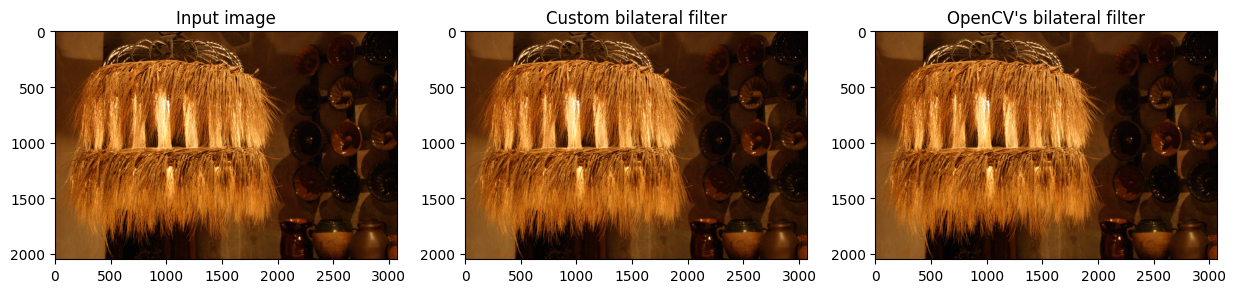

In [ ]:
# Normalize output images
custom_norm = (filtered_custom - np.min(filtered_custom)) / (np.max(filtered_custom) - np.min(filtered_custom))
cv_norm = (filtered_cv - np.min(filtered_cv)) / (np.max(filtered_cv) - np.min(filtered_cv))

# Display images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image_norm)
axs[0].set_title("Input image")
axs[1].imshow(custom_norm)
axs[1].set_title("Custom bilateral filter")
axs[2].imshow(cv_norm)
axs[2].set_title("OpenCV's bilateral filter")
plt.show()


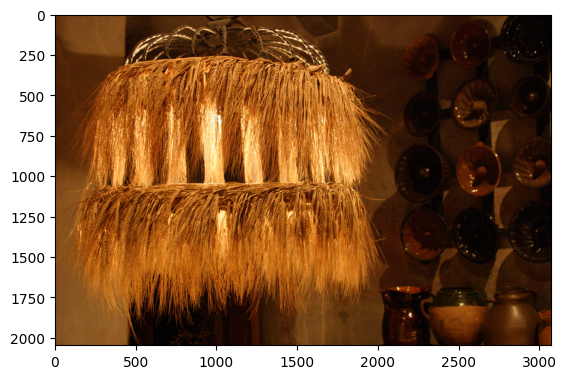

In [ ]:
plt.imshow(cv_norm)

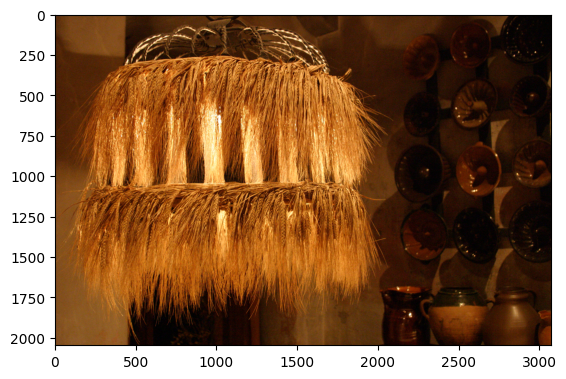

In [ ]:
cv_norm = (filtered_cv - np.min(filtered_cv)) / (np.max(filtered_cv) - np.min(filtered_cv))
plt.imshow(filtered_cv)
plt.show()

## Implementing joint-bilateral filtering

In [ ]:
def joint_bilateral_filtering(ambient_image, flash_image, kernel_size, sigma_spatial, sigma_range):

    
    # Compute the minimum and maximum pixel intensities in the flash image
    intensity_epsilon = 0.01
    min_intensity = np.min(flash_image) - intensity_epsilon
    max_intensity = np.max(flash_image) + intensity_epsilon

    # Determine the number of intensity segments needed
    nb_segments = int(np.ceil((max_intensity - min_intensity) / sigma_range))
    
    # Allocate an array to store the filtered image for each intensity segment
    filtered_segments = np.zeros((nb_segments, *ambient_image.shape))

    # Compute the Gaussian filter kernel and apply it to the input image for each intensity segment
    for segment_idx in range(nb_segments):
        intensity_segment = min_intensity + segment_idx * (max_intensity - min_intensity) / nb_segments
        intensity_weights = np.exp(-((flash_image - intensity_segment) ** 2) / (2 * sigma_range**2))  # use gaussian as g(x)
        spatial_weights = cv2.GaussianBlur(intensity_weights, (kernel_size, kernel_size), sigma_spatial)
        product_image = intensity_weights * ambient_image
        product_image = cv2.GaussianBlur(product_image, (kernel_size, kernel_size), sigma_spatial)
        filtered_segment = product_image / spatial_weights
        filtered_segments[segment_idx, :] = filtered_segment
        
    gc.collect()
    # Interpolate the filtered values for each color channel separately
    filtered_channels = []
    for color_channel_idx in range(3):
        x_values, y_values = np.arange(ambient_image.shape[1]), np.arange(ambient_image.shape[0])
        vx, vy = np.meshgrid(x_values, y_values)
        # Create a 3D grid of intensity, row, and column coordinates
        grid_coords = (np.linspace(min_intensity, max_intensity, nb_segments), y_values, x_values)
        # Select the filtered values for the current color channel
        values = filtered_segments[:, :, :, color_channel_idx]
        query_coords = (ambient_image[:, :, color_channel_idx].flatten(), vy.flatten(), vx.flatten())
        # Interpolate the filtered values for the current color channel
        filtered_channels.append(interpn(grid_coords, values, query_coords).reshape(ambient_image.shape[0], ambient_image.shape[1]))
    gc.collect()
    return np.dstack(filtered_channels)




# Load image
ambient_image = plt.imread(ambient)[::1, ::1]
flash_image = plt.imread(flash)[::1, ::1]
ambient_norm = (ambient_image - np.min(ambient_image)) / (np.max(ambient_image) - np.min(ambient_image))
flash_norm = (flash_image - np.min(flash_image)) / (np.max(flash_image) - np.min(flash_image))





In [ ]:
# Set parameters
kernel_size = 5
sigma_r = 0.05
sigma_s = 40

# Apply custom bilateral filter
j_filtered_custom = joint_bilateral_filtering(ambient_image, flash_image, kernel_size, sigma_s, sigma_r)

# Apply OpenCV's bilateral filter
j_filtered_cv = cv2.ximgproc.jointBilateralFilter(flash_image, ambient_image,  kernel_size, sigma_r, sigma_s)

# Compare outputs
j_mse = np.mean((j_filtered_custom  - j_filtered_cv) ** 2)
if j_mse < 1e-10:
    print("Custom bilateral filter and OpenCV's bilateralFilter function produce the same output.")
else:
    print("Outputs differ. Mean squared error:", mse)

diff_img =  j_filtered_custom - ambient_image
result_norm = get_normalize(j_filtered_custom) 
diff_norm = get_normalize(diff_img)
string_diff= "./out/part1/diff_norm_jbiteral"+"default"+".png"
string_result= "./out/part1/result_norm_jbiteral"+"default"+".png"
io.imsave(string_result,result_norm)
io.imsave(string_diff,diff_norm)
diff_img_f =  j_filtered_custom - flash_image
diff_norm_f = get_normalize(diff_img_f)
string_diff_f= "./out/part1/diff_f_norm_jbiteral"+"default"+".png"
io.imsave(string_diff_f,diff_norm_f)

Custom bilateral filter and OpenCV's bilateralFilter function produce the same output.


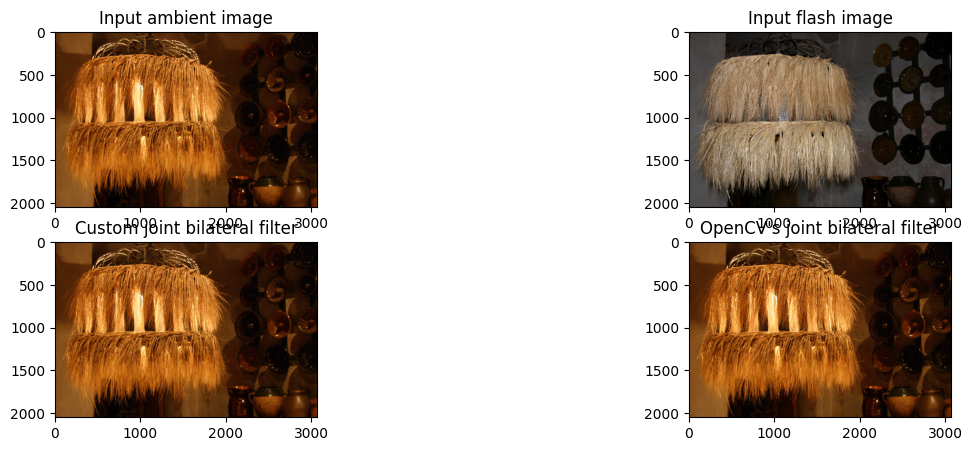

In [ ]:
# Normalize output images
j_custom_norm = (j_filtered_custom - np.min(j_filtered_custom)) / (np.max(j_filtered_custom) - np.min(j_filtered_custom))
j_cv_norm = (j_filtered_cv - np.min(j_filtered_cv)) / (np.max(j_filtered_cv) - np.min(j_filtered_cv))
# Display images
fig, axs = plt.subplots(2, 2, figsize=(15, 5))
axs[0][0].imshow(ambient_norm)
axs[0][0].set_title("Input ambient image")
axs[0][1].imshow(flash_norm)
axs[0][1].set_title("Input flash image")
axs[1][0].imshow(j_custom_norm)
axs[1][0].set_title("Custom joint bilateral filter")
axs[1][1].imshow(j_cv_norm)
axs[1][1].set_title("OpenCV's joint bilateral filter")
plt.show()



## Implementing detail transfer

In [ ]:
#Simply Calculates the Adetail as described in PDF
def get_detail_transfer(ambient_image, flash_image,epsilon, kernel_size, sigma_spatial, sigma_range):
    F_base = bilateral_filtering(flash_image, kernel_size, sigma_spatial, sigma_range)
    ANR = joint_bilateral_filtering(ambient_image, flash_image, kernel_size, sigma_spatial, sigma_range)
    Fraction = (flash_image+epsilon)/(F_base+epsilon)
    Adetail = ANR * Fraction
    gc.collect()
    return Adetail

100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


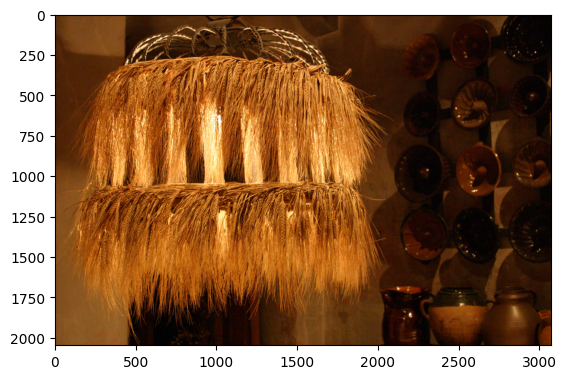

In [ ]:
epsilon = 0.001
A_detail_transfer = get_detail_transfer(ambient_image, flash_image,epsilon, kernel_size, sigma_s, sigma_r)
detail_transfer_norm = get_normalize(A_detail_transfer)
plt.imshow(detail_transfer_norm)

diff_img =  A_detail_transfer - ambient_image
result_norm = get_normalize(A_detail_transfer) 
diff_norm = get_normalize(diff_img)
string_diff= "./out/part1/diff_norm_detail"+"default"+".png"
string_result= "./out/part1/result_norm_detail"+"default"+".png"
io.imsave(string_result,result_norm)
io.imsave(string_diff,diff_norm)
diff_img_f =  A_detail_transfer - flash_image
diff_norm_f = get_normalize(diff_img_f)
string_diff_f= "./out/part1/diff_f_norm_detail"+"default"+".png"
io.imsave(string_diff_f,diff_norm_f)

## Implementıng shadow and specularity masking

In [ ]:
def get_linear_image(image) :
    zero_points = np.where(image <= 0.0404482)
    one_points = np.where(image > 0.0404482)

    lin_img = np.copy(image)

    lin_img[zero_points] = image[zero_points]/12.92
    lin_img[one_points] = ((image[one_points] + 0.055)/1.055)**2.4
    return lin_img 

def get_M(ambient_image, flash_image,kernel_size):
    ## Some of the above found from ethernet since the PDF suggest e using morphological filtering operations (dilation, ero-
    ## sion, opening, and closing) to post-process the individual shadow and specularity mask before combining them to form the mask M
    ambient_norm = get_normalize(ambient_image)
    flash_norm = get_normalize(flash_image)
    amb_norm_lin = get_linear_image(ambient_norm)
    flash_norm_lin = get_linear_image(flash_norm)

    
    ## Since ISO range is 100 200 400 800 1600 and for flash 200 Ambient 1600
    amb_norm_lin = amb_norm_lin * (200/1600)

    ## Get_luminance
    lmnnc_amb = cv2.cvtColor(amb_norm_lin[:, :, ::-1].astype('float32'), cv2.COLOR_BGR2YCR_CB)[:, :, 0]
    lmnnc_flash = cv2.cvtColor(flash_norm_lin[:, :, ::-1].astype('float32'), cv2.COLOR_BGR2YCR_CB)[:, :, 0]

    ##Constants      
    map_spcle = np.zeros(lmnnc_amb.shape)
    map_shadow =  np.zeros(lmnnc_amb.shape)
    ##clears noise
    opening_kernel = np.ones((3,3),np.uint8)
    ##fills holes
    closing_kernel = np.ones((8,8),np.uint8) 
    dilation_kernel = np.ones((20,20),np.uint8)

    
    ## 0.95 choosen to detect specle noises   
    map_spcle[lmnnc_flash > 0.95] = 1
    map_spcle_opened = cv2.morphologyEx(map_spcle, cv2.MORPH_OPEN, opening_kernel)
    map_spcle_closed = cv2.morphologyEx(map_spcle_opened, cv2.MORPH_CLOSE, closing_kernel)
    map_spcle_dilated = cv2.dilate(map_spcle_closed,dilation_kernel)

    ##0.0005 choosen for map shadows
    map_shadow[np.abs(lmnnc_flash - lmnnc_amb) <= 0.0005] = 1
    map_shadow_opened = cv2.morphologyEx(map_shadow, cv2.MORPH_OPEN, opening_kernel)
    map_shadow_closed = cv2.morphologyEx(map_shadow_opened, cv2.MORPH_CLOSE, closing_kernel)
    map_shadow_dilated = cv2.dilate(map_shadow_closed,dilation_kernel)

    ##Final Mapping
    map = map_shadow_dilated.copy()
    map[map_spcle_dilated==1] = 1
    map_blurred = cv2.GaussianBlur(map,[kernel_size,kernel_size],75)
    plt.imshow(map_blurred)
    map_3channel = np.repeat(np.expand_dims(map_blurred,2),3, axis=2)

    return map_3channel

def get_shadow_and_spec(ambient_image, flash_image,epsilon, kernel_size, sigma_spatial, sigma_range):
    A = bilateral_filtering(ambient_image, kernel_size, sigma_spatial, sigma_range)
    Abase = get_normalize(A)
    M = get_M(ambient_image, flash_image,kernel_size)
    A_detail_transfer = get_detail_transfer(ambient_image, flash_image,epsilon, kernel_size, sigma_s, sigma_r)
    Adetail = get_normalize(A_detail_transfer)
    gc.collect()
    return  ((1-M)*Adetail + (M * Abase))




<ipython-input-19-4506056b1e65>:9: UserWarning: ./out/part1/diff_shadow_maskdefault.png is a low contrast image
  io.imsave(string_diff,diff_norm)


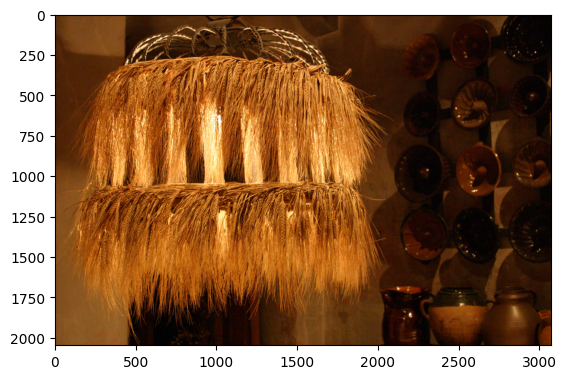

In [ ]:
shadow_and_spec = get_shadow_and_spec(ambient_image, flash_image,epsilon, kernel_size, sigma_s, sigma_r)

diff_img =  shadow_and_spec - get_normalize(ambient_image)
result_norm = shadow_and_spec
diff_norm = diff_img
string_diff= "./out/part1/diff_shadow_mask"+"default"+".png"
string_result= "./out/part1/result_shadow_mask"+"default"+".png"
io.imsave(string_result,result_norm)
io.imsave(string_diff,diff_norm)
plt.imshow(shadow_and_spec)
diff_img_f =  shadow_and_spec- get_normalize(flash_image)
string_diff_f= "./out/part1/diff_f_norm_mask"+"default"+".png"
io.imsave(string_diff_f,diff_img_f)


## Implementation details.

In [ ]:
sigma_r_values = [0.05,0.10,0.15,0.20]
sigma_s_values = [0.1, 1, 5, 10, 40]
kernel_values = [1,5,11,17]

str_sigma_r_values = ["0_05","0_10","0_15","20"]
str_sigma_s_values = ["0_1", "1","5", "10", "40"]
str_kernel_values = ["1","5","11","17"]

## Joint Bilateral Filtering

## Detail Transfer

## Shadow and masking

In [ ]:
## Bilateral Filtering effect of sigma_s
# ram not enough for for loop 
for i in tqdm.tqdm(range(0,len(sigma_s_values))):
    sigma_s = sigma_s_values[i]
    sigma_r = 0.05
    kernel_size= 11
    result_bil=bilateral_filtering(image_norm, kernel_size, sigma_s, sigma_r)
    diff_img =  result_bil - ambient_image
    result_norm = get_normalize(result_bil) 
    diff_norm = get_normalize(diff_img)
    string_diff= "./out/part1/s/diff_norm_biteral"+str_sigma_s_values[i]+".png"
    string_result= "./out/part1/s/result_norm_biteral"+str_sigma_s_values[i]+".png"
    io.imsave(string_result,result_norm)
    io.imsave(string_diff,diff_norm)
    gc.collect()

100%|██████████| 5/5 [02:44<00:00, 32.85s/it]


In [ ]:
## Bilateral Filtering effect of sigma_s
# ram not enough for for loop 
for i in tqdm.tqdm(range(0,len(sigma_r_values))):
    sigma_s = 5
    sigma_r = sigma_r_values[i]
    kernel_size= 11
    result_bil=bilateral_filtering(image_norm, kernel_size, sigma_s, sigma_r)
    diff_img =  get_normalize(result_bil) - image_norm
    result_norm = get_normalize(result_bil) 
    diff_norm = get_normalize(diff_img)
    string_diff= "./out/part1/r/diff_norm_biteral"+str_sigma_r_values[i]+".png"
    string_result= "./out/part1/r/result_norm_biteral"+str_sigma_r_values[i]+".png"
    io.imsave(string_result,result_norm)
    io.imsave(string_diff,diff_norm)
    gc.collect()

100%|██████████| 4/4 [02:09<00:00, 32.44s/it]


In [ ]:
## Bilateral Filtering effect of sigma_s
# ram not enough for for loop 
for i in tqdm.tqdm(range(0,len(kernel_values))):
    sigma_s = 5
    sigma_r = sigma_r_values[i]
    kernel_size= 11
    result_bil=bilateral_filtering(image_norm, kernel_size, sigma_s, sigma_r)
    diff_img =  result_bil - image_norm
    result_norm = get_normalize(result_bil) 
    diff_norm = get_normalize(diff_img)
    string_diff= "./out/part1/k/diff_norm_biteral"+str_kernel_values[i]+".png"
    string_result= "./out/part1/k/result_norm_biteral"+str_kernel_values[i]+".png"
    io.imsave(string_result,result_norm)
    io.imsave(string_diff,diff_norm)
    gc.collect()

100%|██████████| 4/4 [01:58<00:00, 29.62s/it]


In [ ]:
## Compare Algorithms
sigma_s = sigma_s_values[2]
sigma_r = sigma_r_values[0]
kernel_size= kernel_s_values[1]
result_bil=joint_bilateral_filtering(ambient_image,flash_image, kernel_size, sigma_s, sigma_r)
diff_img =  result_bil - ambient_image
result_norm = get_normalize(result_bil) 
diff_norm = get_normalize(diff_img)
string_diff= "./out/part1/diff_norm_biteral"+str(i)+"_"+"5"+"_"+"0_1"+"_"+".png"
string_result= "./out/part1/result_norm_biteral"+str(i)+"_"+"5"+"_"+"0_1"+"_"+".png"
io.imsave(string_result,result_norm)
io.imsave(string_diff,diff_norm)
gc.collect()



# Gradient-domain processing

In [7]:
 import matplotlib.image as mpimg
 from scipy.signal import convolve2d

Text(0.5, 1.0, 'Input flash image')

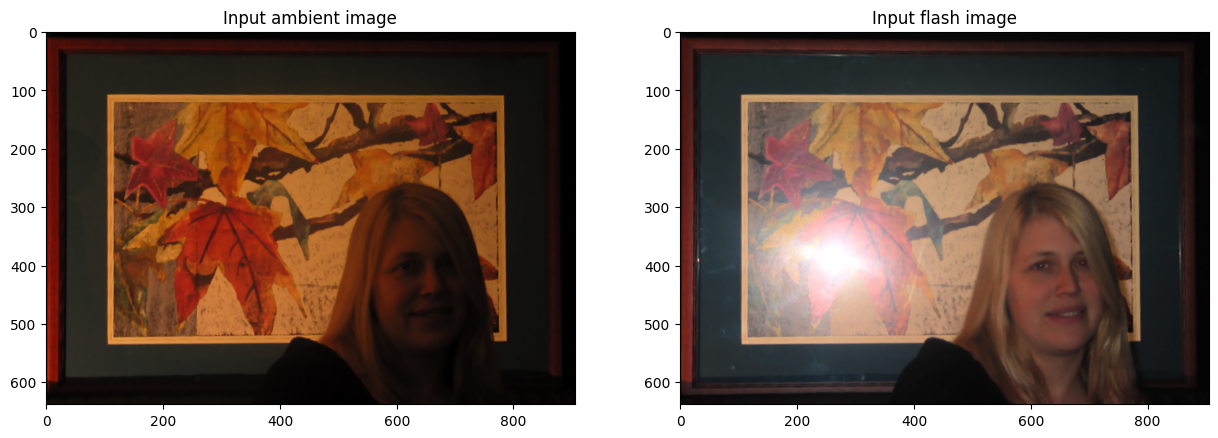

In [8]:
# Read the PNG file
msm_ambient_img = mpimg.imread(msm_ambient)[:,:,:3]
msm_flash_img = mpimg.imread(msm_flash)[:,:,:3]

# plot the PNG file
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(msm_ambient_img)
axs[0].set_title("Input ambient image")
axs[1].imshow(msm_flash_img)
axs[1].set_title("Input flash image")

In [9]:
print(np.shape(msm_ambient_img ))
test = (cv2.imread(msm_ambient,-1)[:,:,:3][:,:,::-1])/255
print(np.shape(test))
print(np.shape(test[:,:,0]))

(638, 905, 3)
(638, 905, 3)
(638, 905)


## Differentiate and then re-integrate an image

In [10]:
def get_gradient(image) : 
    #To fix size prepend the image
    temp = image[:,:].copy()
    row = np.zeros((1,temp.shape[1]));col = np.zeros((temp.shape[0]+2,1))
    temp2 = np.hstack((col,np.hstack((np.vstack((row,np.vstack((temp, row)))), col))))
    #Along rows
    Ix = np.diff(temp2,n=1,axis=1) 
    #Along columns
    Iy = np.diff(temp2,n=1,axis=0) 
    return Ix, Iy 

def get_divergence(Ix, Iy):

    Ixx = np.diff(Ix, 1, axis=1)
    Iyy = np.diff(Iy, 1, axis=0)
    Ixx, Iyy = Ixx[1:-1,:],Iyy[:,1:-1]
    divergence = Ixx + Iyy
    return divergence

def get_laplacian(image):
    filter = np.array([[0,1,0],[1,-4,1],[0,1,0]])
    laplacian = np.zeros(np.shape(image))
    for channel in range(3):
      laplacian[:,:,channel] = convolve2d(image[:,:,channel], filter, mode='same', boundary='fill', fillvalue=0)
    return laplacian 



#def get_laplacian(image):
#    filter = np.array([[0,1,0],[1,-4,1],[0,1,0]])
#    laplacian = np.zeros(np.shape(image))
#    for channel in range(3):
#      laplacian[:,:,channel] = convolve2d(image[:,:,channel], filter, mode='same', boundary='fill', fillvalue=0)
#    return laplacian 

def get_laplacian(image):
    filter = np.array([[0,1,0],[1,-4,1],[0,1,0]])
    return convolve2d(image, filter, mode='same', boundary='fill', fillvalue=0)

def conjugate_gradient_descent(I_init, B, I_star_boundary, e, N, D) :
    # Initialization
    I_star = B * I_init + (1-B) * I_star_boundary
    r = B * (D - get_laplacian(I_star))
    d = r.copy() 
    delta_new = np.sum(r*r) # <r,r>
    n = 0
    
    # conjugate gradient descent iteration
    while np.sqrt(np.sum(r*r)) > e and n < N :
        
        q = get_laplacian(d)
        eta = delta_new / np.sum(d*q) 
        I_star = I_star + B * (eta * d)
        r = B * (r - eta * q)    
        delta_old = delta_new.copy()
        delta_new = np.sum(r*r)
        beta = delta_new / delta_old 
        d = r + beta * d   
    
        n = n + 1
        
    return I_star


True


Text(0.5, 1.0, 'True if its one color which is purple')

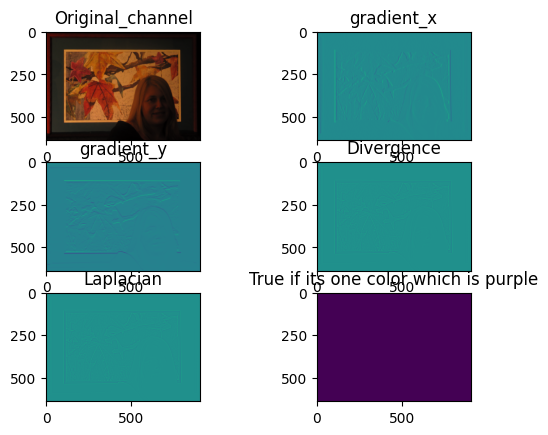

In [11]:
gradient_x,gradient_y  = get_gradient(msm_ambient_img[:,:,0])
diverengence_ımg = get_divergence(gradient_x,gradient_y )
laplacian_ımg = get_laplacian(msm_ambient_img[:,:,0])
print(np.allclose(diverengence_ımg, laplacian_ımg))
fig, ax = plt.subplots(3, 2)
ax[0][0].imshow(msm_ambient_img)
ax[0][0].set_title("Original_channel")
ax[0][1].imshow(gradient_x)
ax[0][1].set_title("gradient_x")
ax[1][0].imshow(gradient_y)
ax[1][0].set_title("gradient_y")
ax[1][1].imshow(diverengence_ımg)
ax[1][1].set_title("Divergence")
ax[2][0].imshow(laplacian_ımg)
ax[2][0].set_title("Laplacian")
ax[2][1].imshow(np.around(diverengence_ımg,5) == np.around(laplacian_ımg,5))
ax[2][1].set_title("True if its one color which is purple")

In [12]:
def poisson_solver(laplacian, image, I_init, I_star_boundary, Max_iteration = 1000, epsilon = 0.001) :
    

    B = np.ones(image.shape)

    B[0:1,:]=0
    B[-1:-1,:]=0
    B[:,0:1]=0
    B[:,-1:-1] = 0
      
    I_star_boundary[0:1,:] = image[0:1,:].copy()
    I_star_boundary[-1:-1,:] = image[-1:-1,:].copy()
    I_star_boundary[:,0:1] = image[:,0:1].copy()
    I_star_boundary[:,-1:-1] = image[:,-1:-1].copy()
    
    I_star= conjugate_gradient_descent(I_init, B, I_star_boundary, epsilon, Max_iteration , laplacian) 
  
    return I_star




In [ ]:
# Laplacian (Divergence of gradient field)

I_star = np.zeros(np.shape(msm_ambient_img))
for channel in range(3):
  laplacian = get_laplacian(msm_ambient_img[:,:,channel])
  temp = poisson_solver(laplacian, msm_ambient_img[:,:,channel],np.zeros(msm_ambient_img[:,:,channel].shape),np.zeros(msm_ambient_img[:,:,channel].shape))
  I_star[:,:,channel]=temp


I_star = np.concatenate((np.expand_dims(I_star[:,:,0],2),np.stack((I_star[:,:,1],I_star[:,:,2]),axis=-1)),axis=2)


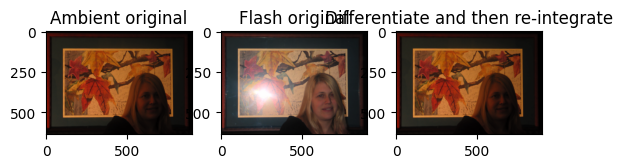

In [ ]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(msm_ambient_img)
ax[0].set_title("Ambient original")
ax[1].imshow(msm_flash_img)
ax[1].set_title("Flash original")
ax[2].imshow(I_star)
ax[2].set_title("Differentiate and then re-integrate") 
plt.show()

## Create the fused gradient field

In [13]:
def GOC_map(msm_ambient_img, msm_flash_img,a_x,a_y,f_x,f_y ):
    #Computes GOC map M
    M = np.abs(a_x * f_x + a_y * f_y)
    magtitude = np.sqrt(a_x**2 + a_y**2) * np.sqrt(f_x**2 + f_y**2) + 0.005
    mask = np.where(magtitude < 0.005, 0, 1)
    M = M / (magtitude+0.00001)
    return M, mask  


def new_gradient_field(ws,M,grad_a,grad_f):
   #Calculates new gradients
   return ws * grad_a + (1-ws) * (M * grad_f + (1-M) * grad_a)

def pixel_wise_satur(msm_flash_img,shape,sigma,tau_s):
    ws = np.zeros(shape)
    ws[:-1,:-1] = np.tanh(sigma * (msm_flash_img-tau_s))
    ws = (ws - np.min(ws)) / (np.max(ws) - np.min(ws))
    return ws

def fuse_gradient_field(msm_ambient_img, msm_flash_img, sigma, tau_s) : 
    a_x, a_y = get_gradient(msm_ambient_img)
    f_x, f_y = get_gradient(msm_flash_img)
    new_grad_f_x = np.zeros(a_x.shape)
    new_grad_f_y = np.zeros(a_y.shape)
    a_x, a_y = a_x[1:,:], a_y[:,1:]
    f_x, f_y = f_x[1:,:],  f_y[:,1:]
    #Step 1 # computes gradient orientation coherency map M
    M, mask = GOC_map(msm_ambient_img, msm_flash_img,a_x,a_y,f_x,f_y )
    # Step 2 Computes the pixel-wise saturation weight  
    ws = pixel_wise_satur(msm_flash_img,a_x.shape,sigma,tau_s)
    # Step 3 Calculating New gradient
    
    new_grad_f_x[1:,:] = new_gradient_field(ws,M,a_x,f_x)
    new_grad_f_y[:,1:] = new_gradient_field(ws,M,a_y,f_y)
    
    return get_divergence(new_grad_f_x,new_grad_f_y)

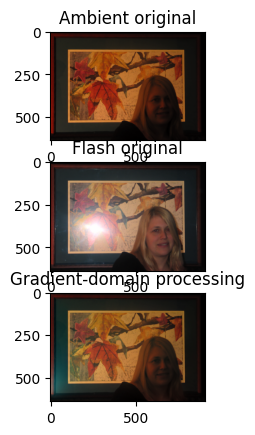

In [ ]:
sigma = 40
tau = 0.7
I_star = np.zeros(np.shape(msm_ambient_img))
for channel in range(3):
  fused_image= fuse_gradient_field(msm_ambient_img[:,:,channel], msm_flash_img[:,:,channel], sigma, tau)
  I_star[:,:,channel] = poisson_solver(fused_image, msm_ambient_img[:,:,0], np.zeros(msm_ambient_img[:,:,channel].shape), np.zeros(msm_ambient_img[:,:,channel].shape),Max_iteration = 5000, epsilon=0.001)

I_star = np.concatenate((np.expand_dims(I_star[:,:,0],2),np.stack((I_star[:,:,1],I_star[:,:,2]),axis=-1)),axis=2)

fig, ax = plt.subplots(3,1)
ax[0].imshow(msm_ambient_img)
ax[0].set_title("Ambient original")
ax[1].imshow(msm_flash_img)
ax[1].set_title("Flash original")
ax[2].imshow(I_star)
ax[2].set_title("Gradient-domain processing") 
plt.show()

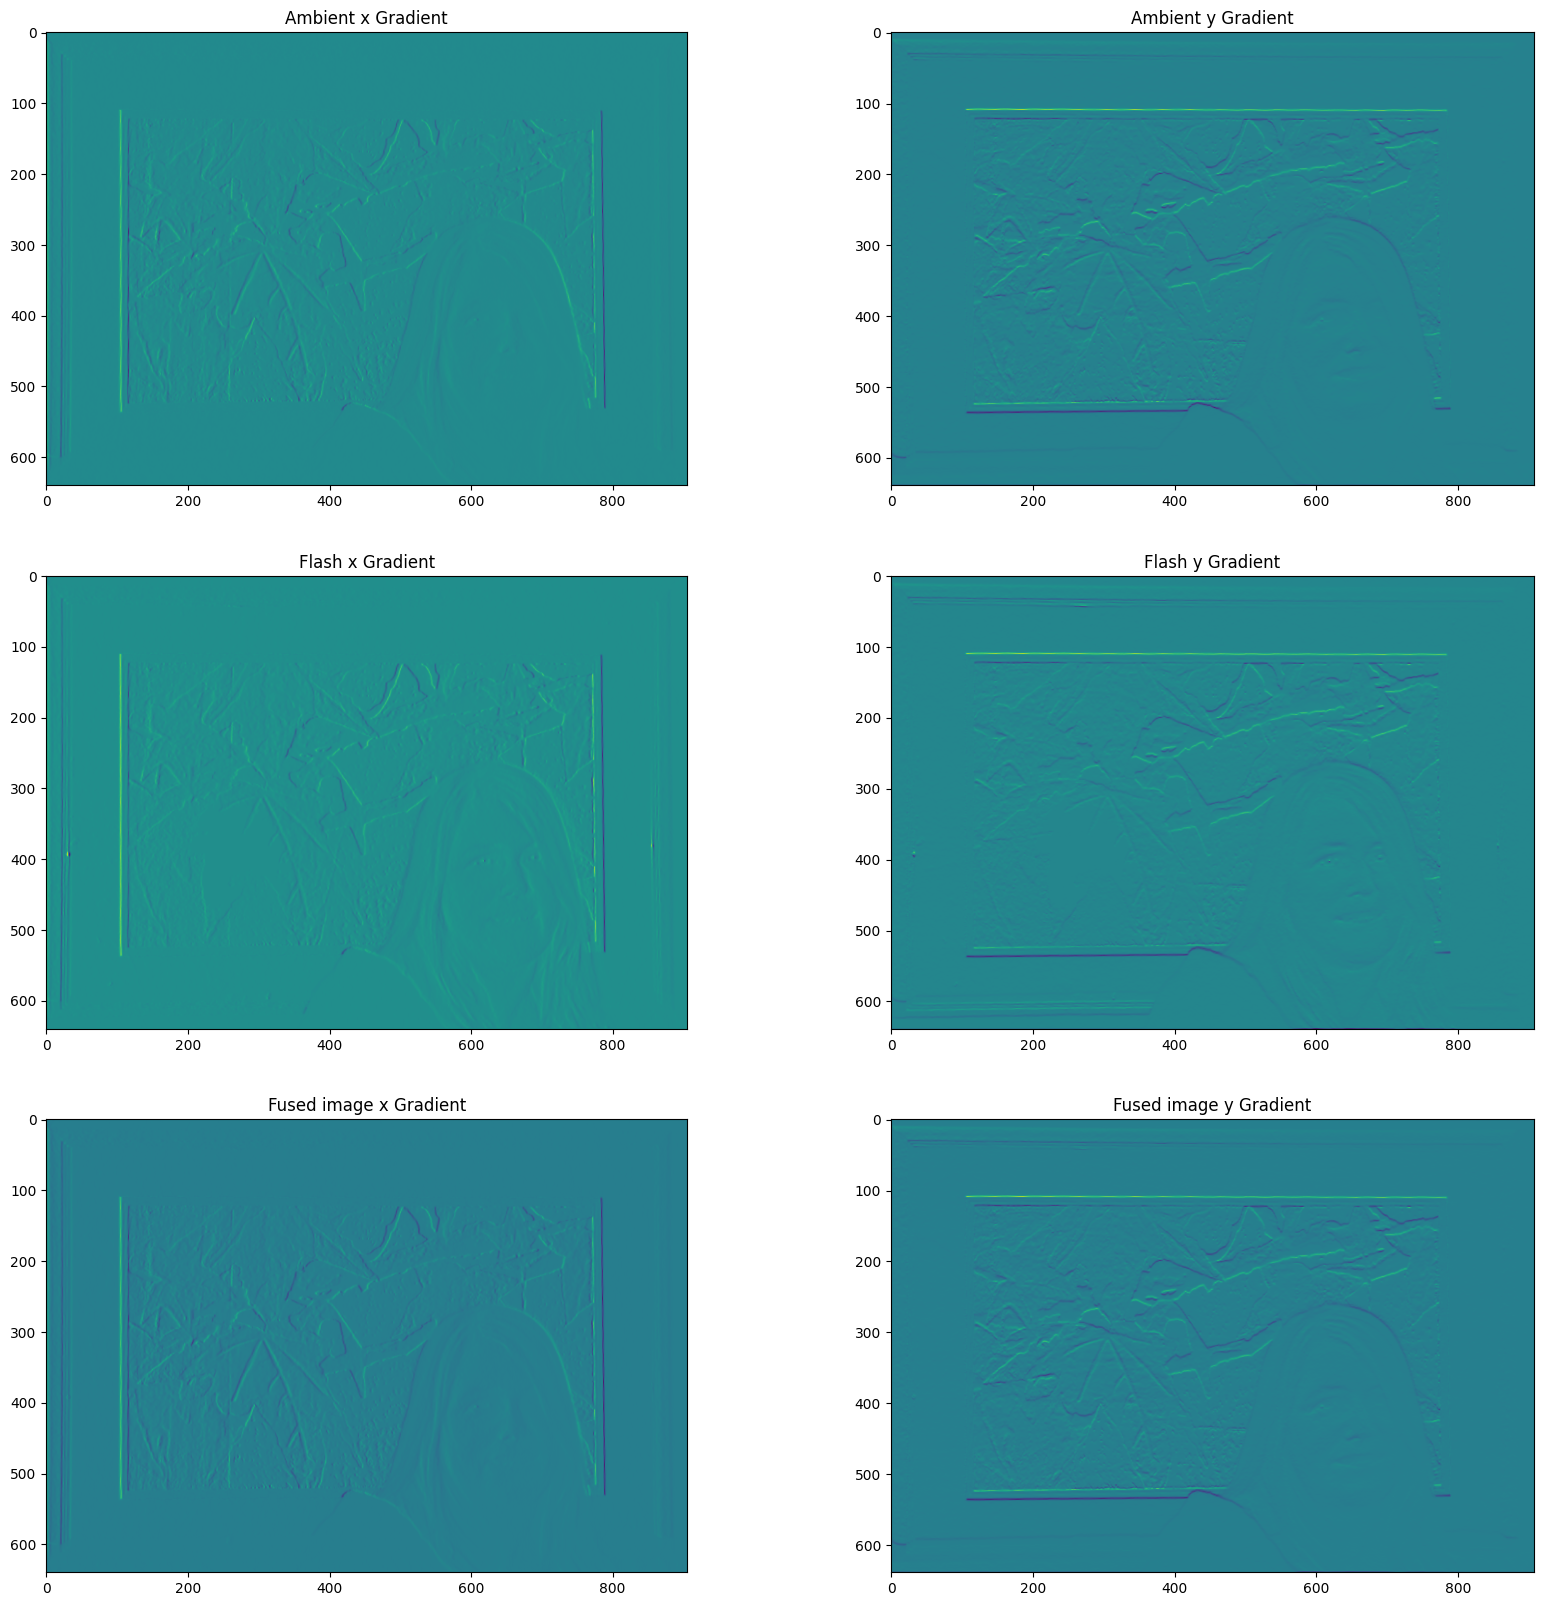

In [ ]:
aa_x, aa_y = get_gradient(msm_ambient_img[:,:,0])
ff_x, ff_y = get_gradient(msm_flash_img[:,:,0])
II_x, II_y = get_gradient(I_star[:,:,0])

fig, ax = plt.subplots(3,2, figsize=(20, 20))
ax[0][0].imshow(aa_x)
ax[0][0].set_title("Ambient x Gradient")
ax[0][1].imshow(aa_y)
ax[0][1].set_title("Ambient y Gradient")
ax[1][0].imshow(ff_x)
ax[1][0].set_title("Flash x Gradient")
ax[1][1].imshow(ff_y)
ax[1][1].set_title("Flash y Gradient")
ax[2][0].imshow(II_x)
ax[2][0].set_title("Fused image x Gradient") 
ax[2][1].imshow(II_y)
ax[2][1].set_title("Fused image y Gradient") 
plt.show()

In [ ]:
conditions=[msm_ambient_img[:,:,channel],msm_flash_img[:,:,channel],(msm_flash_img[:,:,channel]+msm_ambient_img[:,:,channel])/2,np.zeros(msm_ambient_img[:,:,channel].shape)]
str_conditions=["]ambient","flash","avarage","zeros"]
for i in tqdm.tqdm(range(0,len(conditions))):
  for j in range(0,len(conditions)):

    I_star = np.zeros(np.shape(msm_ambient_img))
    I_star = np.zeros(np.shape(msm_ambient_img))
    for channel in range(3):
      fused_image= fuse_gradient_field(msm_ambient_img[:,:,channel], msm_flash_img[:,:,channel], sigma, tau)
      I_star[:,:,channel] = poisson_solver(fused_image, msm_ambient_img[:,:,0], conditions[i] , conditions[j],Max_iteration = 5000, epsilon=0.001)

    I_star =  get_normalize(np.concatenate((np.expand_dims(I_star[:,:,0],2),np.stack((I_star[:,:,1],I_star[:,:,2]),axis=-1)),axis=2))
    str_to_save = "./out/part2/input"+str_conditions[i]+"_"+"boundry"+str_conditions[j]+".png"
    plt.imsave(str_to_save,I_star)

100%|██████████| 4/4 [22:19<00:00, 334.86s/it]


# Bonus Part 3

In [14]:
my_ambient =  './own_photo/bonus3/ambient.jpg'
my_flash = './own_photo/bonus3/flash.jpg'
my_spec_ambient =  './own_photo/bonus3/spec_ambient.jpg'
my_spec_flash = './own_photo/bonus3/spec_flash.jpg'

my_ambient_img = mpimg.imread(my_ambient)[::1,::1,:3][:-50,:,::-1]
my_flash_img = mpimg.imread(my_flash)[::1,::1,:3][:-50,:,::-1]

my_spec_ambient_img = mpimg.imread(my_spec_ambient)[::1,::1,:3][:-50,:,::-1]
my_spec_flash_img = mpimg.imread(my_spec_flash)[::1,::1,:3][:-50,:,::-1]




100%|██████████| 13/13 [00:13<00:00,  1.07s/it]


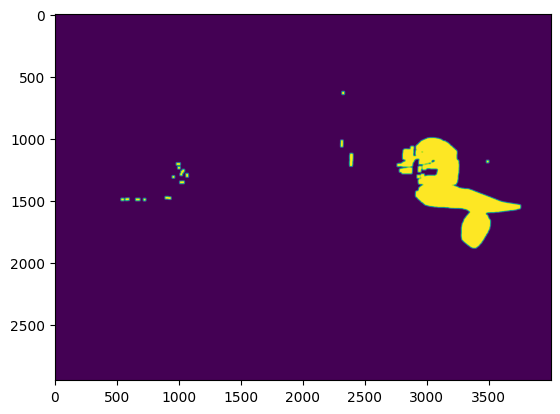

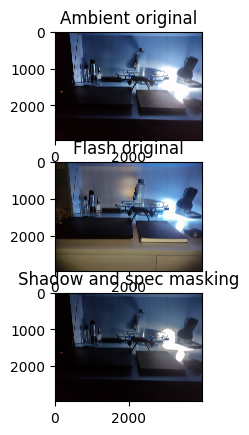

In [ ]:
kernel_size=11; sigma_s=10; sigma_r=0.08
my_shadow_and_spec = get_normalize(get_shadow_and_spec(get_normalize(my_ambient_img), get_normalize(my_flash_img),0.0001, 11, 40, 0.08))

fig, ax = plt.subplots(3,1)
ax[0].imshow(my_ambient_img)
ax[0].set_title("Ambient original")
ax[1].imshow(my_flash_img)
ax[1].set_title("Flash original")
ax[2].imshow(my_shadow_and_spec)
ax[2].set_title("Shadow and spec masking") 
plt.imsave("bonus3_1.png",my_shadow_and_spec)
plt.show()




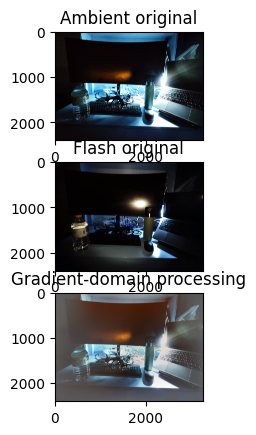

In [16]:
sigma = 10
tau = 0.1
my_spec_ambient_img =get_normalize(my_spec_ambient_img)
my_spec_flash_img = get_normalize(my_spec_flash_img)
my_I_star = np.zeros(np.shape(my_spec_ambient_img))

for channel in range(3):
  zrs=np.zeros(my_spec_ambient_img[:,:,channel].shape)
  fused_image= fuse_gradient_field(my_spec_ambient_img[:,:,channel], my_spec_flash_img[:,:,channel], sigma, tau)
  my_I_star[:,:,channel] = poisson_solver(fused_image, my_spec_ambient_img[:,:,0], zrs, zrs,Max_iteration = 1333, epsilon=0.001)

my_I_star = get_normalize(np.concatenate((np.expand_dims(my_I_star[:,:,0],2),np.stack((my_I_star[:,:,1],my_I_star[:,:,2]),axis=-1)),axis=2))

fig, ax = plt.subplots(3,1)
ax[0].imshow(my_spec_ambient_img)
ax[0].set_title("Ambient original")
ax[1].imshow(my_spec_flash_img)
ax[1].set_title("Flash original")
ax[2].imshow(my_I_star)
ax[2].set_title("Gradient-domain processing") 
plt.imsave("bonus3_2.png",my_I_star)
plt.show()


# Bonus Part 4

In [ ]:
my_ref_ambient =  './own_photo/bonus4/reflect_ambient.jpg'
my_ref_flash = './own_photo/bonus4/reflect_flash.jpg'

my_ref_ambient_img = mpimg.imread(my_ref_ambient )[::1,::1,:3][:-50,:,::-1]
my_ref_flash_img = mpimg.imread(my_ref_flash)[::1,::1,:3][:-50,:,::-1]
my_ref_ambient_norm = get_normalize(my_ref_ambient_img)
my_ref_flash_norm = get_normalize(my_ref_flash_img)
H = my_ref_ambient_norm*2/4  + my_ref_flash_norm*3/4





def b4_gradient_field(ws,h_alpha,grad_a,h_grad_x):
   #Calculates new gradients
   return ws * grad_a + (1-ws) * (h_alpha(h_grad_x ,grad_a))

def new_pixel_wise(msm_flash_img,shape,sigma,tau_s):
    ws = np.zeros(shape)
    ws[:-1,:-1] = 1-np.tanh(sigma * (msm_flash_img-tau_s))
    ws = (ws - np.min(ws)) / (np.max(ws) - np.min(ws))
    return ws
def bonus4_fuse_gradient_field(msm_ambient_img, msm_flash_img, H,sigma,tau_s) : 
    a_x, a_y = get_gradient(msm_ambient_img)
    f_x, f_y = get_gradient(msm_flash_img)
    new_grad_f_x = np.zeros(a_x.shape)
    new_grad_f_y = np.zeros(a_y.shape)
    h_grad_x, h_grad_y = get_gradient(H)
    a_x, a_y = a_x[1:,:], a_y[:,1:]
    f_x, f_y = f_x[1:,:],  f_y[:,1:]
    h_grad_x, h_grad_y = h_grad_x[1:,:], h_grad_y[:,1:]
    h_alpha = lambda h_grad,a_grad : a_grad * (h_grad * a_grad) / np.sqrt(np.sum(a_grad**2)) 

    wu = new_pixel_wise(msm_flash_img,a_x.shape,sigma,tau_s)
    # Step 3 Calculating New gradient
    
    new_grad_f_x[1:,:] = b4_gradient_field(wu,h_alpha,a_x,h_grad_x)
    new_grad_f_y[:,1:] = b4_gradient_field(wu,h_alpha,a_y,h_grad_y)
    
    return get_divergence(new_grad_f_x,new_grad_f_y)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-08608521900e>", line 17, in <cell line: 17>
    plt.imsave("bonus4.png",b4_I_star)
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py", line 2200, in imsave
    return matplotlib.image.imsave(fname, arr, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/image.py", line 1689, in imsave
    image.save(fname, **pil_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/PIL/Image.py", line 2237, in save
    fp = builtins.open(filename, "w+b")
OSError: [Errno 107] Transport endpoint is not connected: 'bonus4.png'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = v

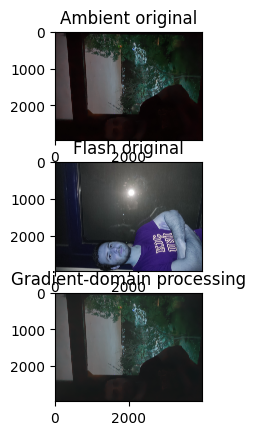

In [ ]:
sigma = 0.01
tau = 0.1
b4_I_star = np.zeros(np.shape(my_ref_ambient_norm))
for channel in range(3):
  fused_image= bonus4_fuse_gradient_field(my_ref_ambient_norm[:,:,channel], my_ref_flash_norm[:,:,channel],H[:,:,channel], sigma, tau)
  b4_I_star[:,:,channel] = poisson_solver(fused_image, my_ref_ambient_norm[:,:,0], np.zeros(my_ref_ambient_norm[:,:,channel].shape), np.zeros(my_ref_ambient_norm[:,:,channel].shape),Max_iteration = 5000, epsilon=0.001)

b4_I_star = get_normalize(np.concatenate((np.expand_dims(b4_I_star[:,:,0],2),np.stack((b4_I_star[:,:,1],b4_I_star[:,:,2]),axis=-1)),axis=2))

fig, ax = plt.subplots(3,1)
ax[0].imshow(my_ref_ambient_norm)
ax[0].set_title("Ambient original")
ax[1].imshow(my_ref_flash_norm)
ax[1].set_title("Flash original")
ax[2].imshow(b4_I_star)
ax[2].set_title("Gradient-domain processing")
plt.imsave("bonus4.png",b4_I_star) 
plt.show()

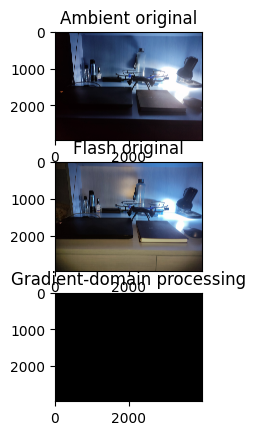

In [ ]:
b4_I_star = np.concatenate((np.expand_dims(b4_I_star[:,:,0],2),np.stack((b4_I_star[:,:,1],b4_I_star[:,:,2]),axis=-1)),axis=2)

fig, ax = plt.subplots(3,1)
ax[0].imshow(my_ref_ambient_norm)
ax[0].set_title("Ambient original")
ax[1].imshow(my_ref_flash_norm)
ax[1].set_title("Flash original")
ax[2].imshow(b4_I_star)
ax[2].set_title("Gradient-domain processing") 
plt.show()

In [ ]:
plt.imsave("bonus4.png",b4_I_star)

In [ ]:
sigma = 0.01
tau = 0.1
b4_I_star = np.zeros(np.shape(my_ref_ambient_norm))
for channel in range(3):
  fused_image= bonus4_fuse_gradient_field(my_ref_ambient_norm[:,:,channel], my_ref_flash_norm[:,:,channel],H[:,:,channel], sigma, tau)
  b4_I_star[:,:,channel] = poisson_solver(fused_image, my_ref_ambient_norm[:,:,0], np.zeros(my_ref_ambient_norm[:,:,channel].shape), np.zeros(my_ref_ambient_norm[:,:,channel].shape),Max_iteration = 5000, epsilon=0.001)

b4_I_star = np.concatenate((np.expand_dims(b4_I_star[:,:,0],2),np.stack((b4_I_star[:,:,1],b4_I_star[:,:,2]),axis=-1)),axis=2)

fig, ax = plt.subplots(3,1)
ax[0].imshow(my_ref_ambient_norm)
ax[0].set_title("Ambient original")
ax[1].imshow(my_ref_flash_norm)
ax[1].set_title("Flash original")
ax[2].imshow(b4_I_star)
ax[2].set_title("Gradient-domain processing")
plt.imsave("bonus4.png",b4_I_star) 
plt.show()

In [ ]:
sigma = 10
tau = 0.1
my_spec_ambient_img =get_normalize(my_spec_ambient_img)
my_spec_flash_img = get_normalize(my_spec_flash_img)
my_I_star = np.zeros(np.shape(my_spec_ambient_img))

for channel in range(3):
  zrs=np.zeros(my_spec_ambient_img[:,:,channel].shape)
  fused_image= fuse_gradient_field(my_spec_ambient_img[:,:,channel], my_spec_flash_img[:,:,channel], sigma, tau)
  my_I_star[:,:,channel] = poisson_solver(fused_image, my_spec_ambient_img[:,:,0], zrs, zrs,Max_iteration = 5000, epsilon=0.001)

my_I_star = get_normalize(np.concatenate((np.expand_dims(my_I_star[:,:,0],2),np.stack((my_I_star[:,:,1],my_I_star[:,:,2]),axis=-1)),axis=2))

fig, ax = plt.subplots(3,1)
ax[0].imshow(my_spec_ambient_img)
ax[0].set_title("Ambient original")
ax[1].imshow(my_spec_flash_img)
ax[1].set_title("Flash original")
ax[2].imshow(my_I_star)
ax[2].set_title("Gradient-domain processing") 
plt.imsave("bonus3_2.png",my_I_star)
plt.show()